# SVO 2: Gendered Subjects

In this notebook, we explore usage of male and female pronouns and nouns as subjects in both subcorpora: first by raw count, and then by actions (verbs) associated with those nouns and pronouns.

**Next Steps**: Work on code to compile / visualize this as a network graph (?).

We begin by loading the SVOs saved to CSVs.

---

**Possible worth looking into**: in a prior code run, we had fed the function a list of pronouns asked it to output only those SVOs: `pronouns = ['i', 'we', 'she', 'he', 'they', 'it', 'you']`. Comparing the two outputs: there are 80,331 SVOs in total in the male speaker subcorpora and 56,781 begin with on of the pronouns listed above and 26,527 total SVOs for the female speaker subcorpus with 18,602 beginning with pronouns, then the preponderance of sentences in TED talks begin with a rather small set of pronouns:

```
male:   56,781 / 80,331 = .706
female: 18,602 / 26,527 = .701
```
*The counts are not precise, but they represent a possible trend worth investigating.*

In [1]:
# IMPORTS
import pandas as pd
import networkx as nx
import numpy as np

# import plotly.graph_objects as go
# import plotly.express as pex

import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

pd.options.plotting.backend = "plotly"

In [2]:
# LOAD DATAFRAMES
svos_m = pd.read_csv("../output/svos_m.csv", index_col=0)
svos_w = pd.read_csv("../output/svos_w.csv", index_col=0)

In [3]:
print(svos_m.shape[0], svos_w.shape[0])

80460 26610


## Subjects

The function below allows us to compare the usage of subjects across the two subcorpora, returning both a raw count and a percentage of the SVO count of the subcorpus.

In [4]:
def compare (subject):
    # Create name:
    m_tmp = svos_m[svos_m["subject"] == subject]
    w_tmp = svos_w[svos_w["subject"] == subject]
    print(f'''
    | ♂︎ "{subject}" | {m_tmp.shape[0]} | {m_tmp.shape[0]/svos_m.shape[0]:.3f} |
    | ♀︎ "{subject}" | {w_tmp.shape[0]} | {w_tmp.shape[0]/svos_w.shape[0]:.3f} |''')
    
compare("he")


    | ♂︎ "he" | 2548 | 0.032 |
    | ♀︎ "he" | 757 | 0.028 |


### Third Person Perspective

In [5]:
thirdPerson = ['he', 'she', 'man', 'woman', 'men', 'women', 'actor', 'actress']

for i in thirdPerson:
    compare(i)


    | ♂︎ "he" | 2548 | 0.032 |
    | ♀︎ "he" | 757 | 0.028 |

    | ♂︎ "she" | 848 | 0.011 |
    | ♀︎ "she" | 643 | 0.024 |

    | ♂︎ "man" | 80 | 0.001 |
    | ♀︎ "man" | 13 | 0.000 |

    | ♂︎ "woman" | 24 | 0.000 |
    | ♀︎ "woman" | 35 | 0.001 |

    | ♂︎ "men" | 40 | 0.000 |
    | ♀︎ "men" | 23 | 0.001 |

    | ♂︎ "women" | 37 | 0.000 |
    | ♀︎ "women" | 62 | 0.002 |

    | ♂︎ "actor" | 3 | 0.000 |
    | ♀︎ "actor" | 1 | 0.000 |

    | ♂︎ "actress" | 0 | 0.000 |
    | ♀︎ "actress" | 0 | 0.000 |


### First & Second Person

In [6]:
firstSecond = ["i", "we", "you"]

for i in firstSecond:
    compare(i)


    | ♂︎ "i" | 15440 | 0.192 |
    | ♀︎ "i" | 6185 | 0.232 |

    | ♂︎ "we" | 15458 | 0.192 |
    | ♀︎ "we" | 4652 | 0.175 |

    | ♂︎ "you" | 11949 | 0.149 |
    | ♀︎ "you" | 3117 | 0.117 |


### Other Subjects

In [7]:
# This is just a placeholder for more interesting words
otherSubjects =  ['subject', 'object']

for i in otherSubjects:
    compare(i)


    | ♂︎ "subject" | 9 | 0.000 |
    | ♀︎ "subject" | 2 | 0.000 |

    | ♂︎ "object" | 7 | 0.000 |
    | ♀︎ "object" | 5 | 0.000 |


## Verbs

We need either a collection of dataframes or one dataframe which has just the subjects above along with the most common verbs: this will give us a sense of the actions associated with particular subjects, the active spaces characters occupy. 

The code below is a sample based on your earlier work. The question is how to do this *at scale*: feeding a list of subjects and then getting 

In [8]:
m_he = svos_m[svos_m["subject"] == "he"].groupby(["verb"]).size().reset_index(
    name='obs').sort_values(['obs'], ascending=False).iloc[:20]
m_he

,verb,obs
293,had,146
581,said,96
284,got,60
282,going,49
297,has,48
711,took,46
519,put,44
758,wanted,44
402,made,37
165,did,36


Below is my attempt to create a function that would return an appropriately named dataframe which was 20 rows long and contained the top 20 verbs for a given subject. It does not work in the `for` loop in the cell below. It returns the dataframe, but the name of the dataframe does not come along for the ride.

In [9]:
def verbCount(dataframe, prefix, subject, num_top_verbs):
    # Create a unique name for the dataframe
    name = (prefix+'_'+subject)
    # Create the [temp] dataframe
    name = dataframe[dataframe["subject"] == subject].groupby(
        ["verb"]).size().reset_index(name='obs').sort_values(
        ['obs'], ascending=False).iloc[:num_top_verbs]
    return name

In [10]:
m_she = verbCount(svos_m, "m", "she", 20)
m_she.head()

,verb,obs
126,had,57
243,said,32
129,has,25
74,did,19
119,going,19


In [11]:
genderedSubjects = ['she', 'he', 'man', 'men', 'woman', 'women']
for i in genderedSubjects:
    verbCount(svos_w, "w", i, 20)

The code above is not working: it is not creating a bunch of smaller dataframes, the following print statement reveals:
```python
print(w_man)
```
```
NameError: name 'w_man' is not defined
```

But I also realized that this is not necessary. One could use the larger dataframe and filter things there or move the SVOS into a network and manipulate things there. (See section below.)

## SVO Networks

### A Small Test Network

While we eventually might like to have a network of `subject > verb > object` for now, let's work with the `m_she` dataframe and build a network with sources, targets, and edge attributes.

In [12]:
# Re-insert a column for "she"
m_she["subject"] = "she"

# Re-arrange columns so that they are in a more obvious order
m_she = m_she[["subject", "verb", "obs"]]

m_she.shape

(20, 3)

In [13]:
# Create the graph
# Reference: https://stackoverflow.com/questions/53937259/converting-a-pandas-dataframe-to-a-networkx-graph
G = nx.from_pandas_edgelist(m_she, source='subject', target='verb', edge_attr=True)

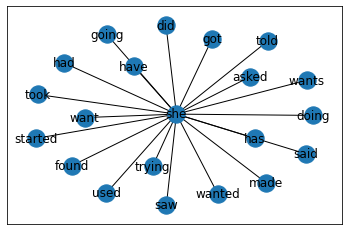

In [14]:
nx.draw_networkx(G)

This is not a very clear graph, and, honestly, I think we would rather be able to choose the number of nodes at the network level rather than at the dataframe level: being able to adjust the network visualization is a real boon.

In [15]:
G.edges.data()

EdgeDataView([('she', 'had', {'obs': 57}), ('she', 'said', {'obs': 32}), ('she', 'has', {'obs': 25}), ('she', 'did', {'obs': 19}), ('she', 'going', {'obs': 19}), ('she', 'told', {'obs': 17}), ('she', 'wanted', {'obs': 16}), ('she', 'started', {'obs': 15}), ('she', 'got', {'obs': 14}), ('she', 'took', {'obs': 13}), ('she', 'trying', {'obs': 11}), ('she', 'have', {'obs': 11}), ('she', 'doing', {'obs': 10}), ('she', 'found', {'obs': 10}), ('she', 'used', {'obs': 9}), ('she', 'made', {'obs': 9}), ('she', 'saw', {'obs': 9}), ('she', 'want', {'obs': 8}), ('she', 'wants', {'obs': 8}), ('she', 'asked', {'obs': 7})])

### Sankey Diagrams

### Plotly

Ken Lok has a terrific [Sankey diagram generator](https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0). (There's also a local copy in the archive.) Plotly is not intuitive, but it looks like their own documentation makes it clear what it expects. 

First, a list of nodes:
```python
nodes = [
    ['ID', 'Label'],
    [0,'Remain+No – 28'],
    [1,'Leave+No – 16'],
    [2,'Remain+Yes – 21']
]
```
Then a list of edges:
```python
links = [
     ['Source','Target','Value'],
     [0,3,20],
     [0,4,3],
     [0,2,5]
]
```

In [16]:
m_she.head()

,subject,verb,obs
126,she,had,57
243,she,said,32
129,she,has,25
74,she,did,19
119,she,going,19


The next two cells are from a [Stackoverflow answer](https://stackoverflow.com/questions/70335771/how-do-i-make-a-sankey-diagram-with-plotly-with-one-layer-that-goes-only-one-lev) by [Rob Raymond](https://stackoverflow.com/users/9441404/rob-raymond).

In [17]:
nodes = np.unique(m_she[["subject", "verb"]], axis=None)
nodes = pd.Series(index=nodes, data=range(len(nodes)))

nodes.head()

asked    0
did      1
doing    2
found    3
going    4
dtype: int64

In [19]:
go.Figure(
    go.Sankey(
        node={"label": nodes.index},
        link={
            "source": nodes.loc[m_she["subject"]],
            "target": nodes.loc[m_she["verb"]],
            "value": m_she["obs"],
        },
    )
)

In [20]:
def sankify(dataframe, subject, num_top_verbs):
    
    # Create the subject-focused dataframe
    df = dataframe[dataframe["subject"] == subject].groupby(
        ["verb"]).size().reset_index(name='obs').sort_values(
        ['obs'], ascending=False).iloc[:num_top_verbs]
    
    # Re-insert a column for the subject
    df["subject"] = subject

    # Re-arrange columns so that they are in a more obvious order
    df = df[["subject", "verb", "obs"]]

    nodes = np.unique(df[["subject", "verb"]], axis=None)
    nodes = pd.Series(index=nodes, data=range(len(nodes)))

    fig = go.Figure(
        go.Sankey(
            node={"label": nodes.index},
            link={
                "source": nodes.loc[df["subject"]],
                "target": nodes.loc[df["verb"]],
                "value": df["obs"],
            },
        )
    )
    return fig

In [21]:
sankify(svos_w, "she", 20)